### Código Fornecido

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from numpy.random import rand
import matplotlib.pylab as plt
import scipy.fftpack

In [3]:
def spikes_poisson(taxa, N_exc, N_ini, peso_exc, peso_ini, dt):
    # Gera N_exc + N_ini entradas Poisson, dados os pesos e a taxa
    
    spikes = rand(N_exc + N_ini) < taxa * dt
    return spikes * np.r_[peso_exc*np.ones(N_exc), peso_ini*np.ones(N_ini)]
    

In [4]:
def espectro(serie, passos, dt):
    # calcula espectro de potências de `série`   
    fr = scipy.fftpack.fftfreq(passos, dt)
    Y = scipy.fftpack.fft(serie)
    
    r_range = range(int(passos/2))
    
    return fr[r_range], abs(Y[r_range]) 

In [5]:
def local_field_potential(I_exc, I_ini, N_exc):
    # calcula sinal de LFP dadas correntes excitatória e inibitória
    R = 1  # Resistência do eletrodo (Mohm)
    return(R/N_exc) * (np.sum(I_exc[:N_exc,:],0)+np.sum(abs(I_ini[:N_exc,:]),0))


In [6]:
def izhikevich(passos, dt, tx_poisson, peso_E, peso_I):
    '''
        Simulação da rede de neurônios descrita em
            Eugene M. Izhikevich. Simple model of spiking neurons.
            IEEE Transactions on neural networks. 14, 6 (2003).
    '''
        
    Ne = 800   # Número de neurônios excitatórios
    Ni = 200   # Número de neurônios inibitórios
    re = rand(Ne) # Ne valores aleatórios entre 0 e 1
    ri = rand(Ni) # Ni valores aleatórios entre 0 e 1
    
    # Parâmetros da simulação
    transiente = passos # no. de pontos a jogar fora (transiente)
    
    # Parâmetros do modelo
    a = np.r_[0.02*np.ones(Ne),  0.02 + 0.08 * ri]
    b = np.r_[0.2*np.ones(Ne),   0.25 - 0.05 * ri]
    c = np.r_[-65+15*re**2,      -65 * np.ones(Ni)]
    d = np.r_[8-6*re**2,         2 * np.ones(Ni)]

    # Pesos Sinápticos
    S = np.c_[0.5*rand(Ne+Ni,Ne), -rand(Ne+Ni,Ni)]

    # Condições iniciais
    v = -65*np.ones(Ne+Ni)    
    u = b * v      
    
    # Matrizes para Correntes
    Ie = np.zeros((Ne+Ni,passos))
    Ii = np.zeros((Ne+Ni,passos))
        
    dt2 = dt * 1000 / 2  # meio passo de integração, em ms
    disparos = []        # lista de spikes

    for _ in range(transiente):  # simular por `transiente` passos de tamanho`dt`
        
        # entrada talâmica
        Iext = spikes_poisson(tx_poisson, Ne, Ni, peso_E, peso_I, dt)

        fired = np.flatnonzero(v >= 30)  # índices das células que dispararam
        v[fired] = c[fired]
        u[fired] = u[fired] + d[fired]
        I = Iext + np.sum(S[:,fired], 1)
        v = v + dt2 * (0.04*v**2 + 5*v + 140 - u + I) # usar dois passos de dt/2
        v = v + dt2 * (0.04*v**2 + 5*v + 140 - u + I) # na dinâmica de v, para
        u = u + 2 * dt2 * (a * (b * v - u))           # maior estabilidade numérica

    for t in range(passos):
        fired = np.flatnonzero(v >= 30)  # índices das células que dispararam
        for nrn in fired:
            disparos.append((nrn, t))
        v[fired] = c[fired]
        u[fired] = u[fired] + d[fired]

        Ie[:,t] = np.sum(S[:,fired[fired<Ne]],1)  # Corrente excitatória
        Ii[:,t] = np.sum(S[:,fired[fired>=Ne]],1) # Corrente inibitória
        
        # entrada talâmica
        Iext = spikes_poisson(tx_poisson, Ne, Ni, peso_E, peso_I, dt)  

        I = Iext + Ie[:,t] + Ii[:,t]

        v = v + dt2 * (0.04*v**2 + 5*v + 140 - u + I) # usar dois passos de dt/2 
        v = v + dt2 * (0.04*v**2 + 5*v + 140 - u + I) # na dinâmica de v, para
        u = u + 2*dt2 * (a * (b * v - u))             # maior estabilidade numérica
    
    
    return disparos, local_field_potential(Ie, Ii, Ne)

## Questão 1
Simluações para a questão 1 com base no exemplo

In [7]:
# Exemplo de simulação da rede 
passos = 2000 # no. de passos na simulação
dt = 0.001 # passo de integração em s
tx_poisson = 100 # taxa em Hz
peso_exc = 15
peso_ini = 6
disparos, LFP = izhikevich(passos, dt, tx_poisson, peso_exc, peso_ini)

<IPython.core.display.Javascript object>


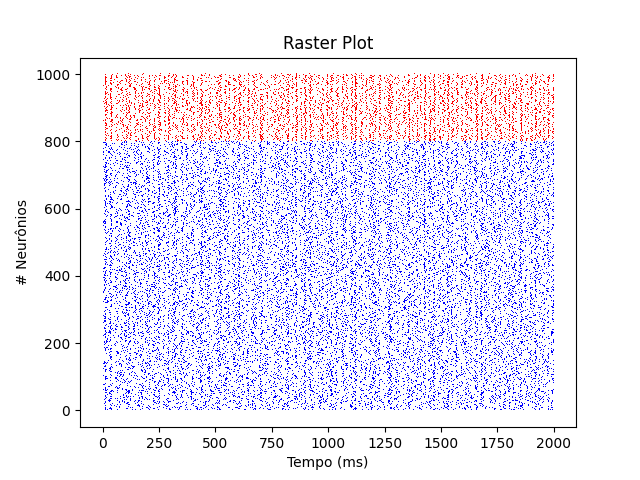

Text(0.5, 1.0, 'Raster Plot')

In [8]:
# Exemplo de raster plot
plt.figure(1)
disparos = np.array(disparos) 
plt.plot(disparos[disparos[:,0]<800,1], disparos[disparos[:,0]<800,0],',b')
plt.plot(disparos[disparos[:,0]>=800,1], disparos[disparos[:,0]>=800,0],',r')
plt.xlabel('Tempo (ms)')
plt.ylabel('# Neurônios')
plt.title('Raster Plot')

<IPython.core.display.Javascript object>


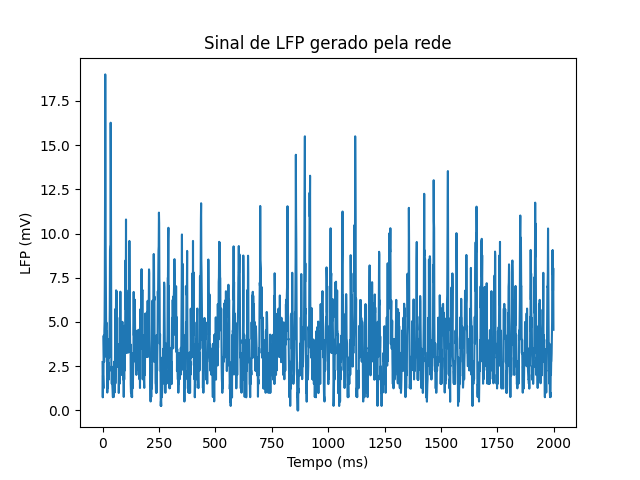

Text(0.5, 1.0, 'Sinal de LFP gerado pela rede')

In [9]:
# Exemplo de sinal de LFP
plt.figure(2)
plt.plot(LFP)
plt.xlabel('Tempo (ms)')
plt.ylabel('LFP (mV)')
plt.title('Sinal de LFP gerado pela rede')

<IPython.core.display.Javascript object>


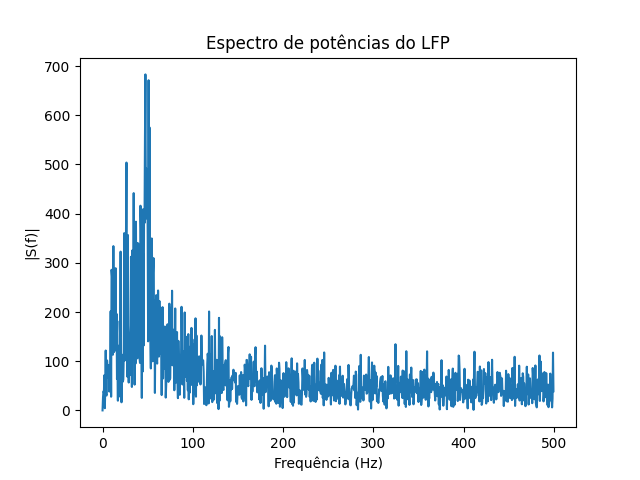

Text(0.5, 1.0, 'Espectro de potências do LFP')

In [10]:
# Exemplo de espectro
freq, S = espectro(LFP-np.mean(LFP), passos, dt)
plt.figure(3)
plt.plot(freq, S)
plt.xlabel('Frequência (Hz)')
plt.ylabel('|S(f)|')
plt.title('Espectro de potências do LFP')

<IPython.core.display.Javascript object>


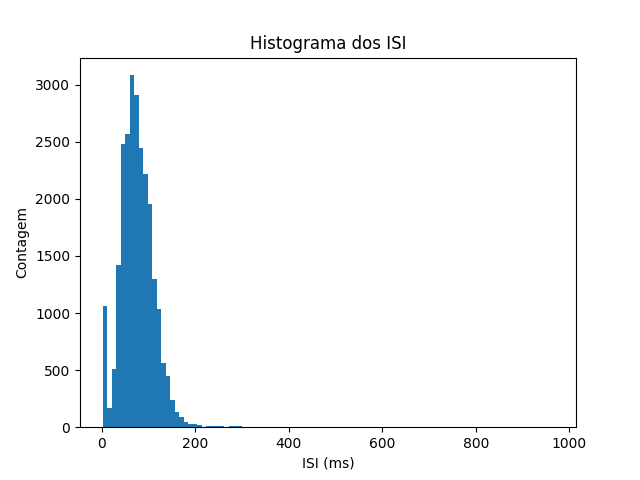

Text(0.5, 1.0, 'Histograma dos ISI')

In [11]:
# Histograma dos ISI

# Dicionário com disparos para cada neurônio
nrn_spikes = {i: [] for i in range(1000)}
for nrn, tspk in disparos:
    nrn_spikes[nrn].append(tspk)

# Lista com todos os ISI
isis = []
for n in nrn_spikes:  # calculamos os ISI para cada um dos neurônios
    tspks = nrn_spikes[n]
    isi = np.diff(tspks)
    isis.extend(isi)  # listona com todos os ISI da rede

plt.figure(4)
plt.hist(isis, bins=100)
plt.xlabel('ISI (ms)')
plt.ylabel('Contagem')
plt.title('Histograma dos ISI')

<IPython.core.display.Javascript object>


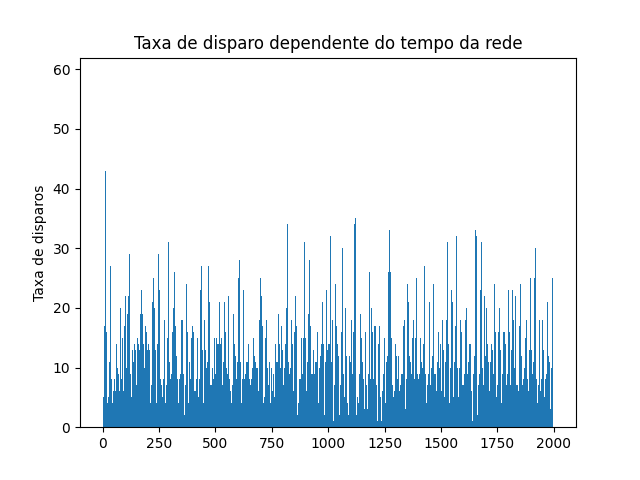

Text(0, 0.5, 'Taxa de disparos')

In [12]:
# Taxa de disparos da rede
plt.figure(5)
plt.hist(disparos[:,1], 2000) # histograma com 2000 canaletas
plt.title('Taxa de disparo dependente do tempo da rede')
plt.ylabel('Taxa de disparos')

## Questão 2

In [24]:
# Exemplo de simulação da rede 
passos_1 = 2000 # no. de passos na simulação
dt_1 = 0.001 # passo de integração em s
tx_poisson_1 = 100 # taxa em Hz
peso_exc_1 = 20
peso_ini_1 = 3
disparos_1, LFP_1 = izhikevich(passos_1, dt_1, tx_poisson_1, peso_exc_1, peso_ini_1)

<IPython.core.display.Javascript object>


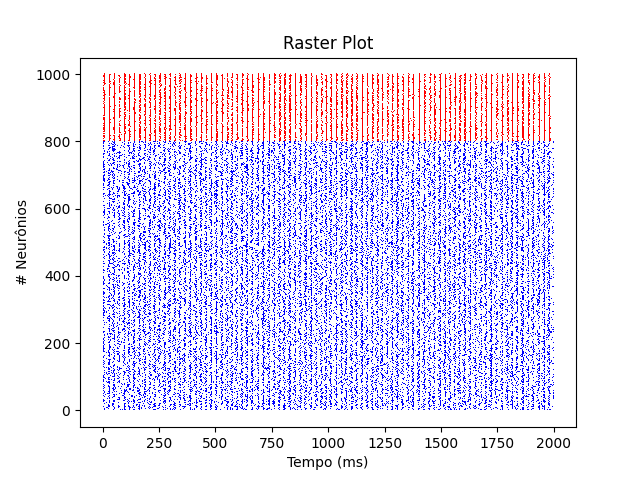

Text(0.5, 1.0, 'Raster Plot')

In [25]:
# Exemplo de raster plot
plt.figure(6)
disparos_1 = np.array(disparos_1) 
plt.plot(disparos_1[disparos_1[:,0]<800,1], disparos_1[disparos_1[:,0]<800,0],',b')
plt.plot(disparos_1[disparos_1[:,0]>=800,1], disparos_1[disparos_1[:,0]>=800,0],',r')
plt.xlabel('Tempo (ms)')
plt.ylabel('# Neurônios')
plt.title('Raster Plot')

<IPython.core.display.Javascript object>


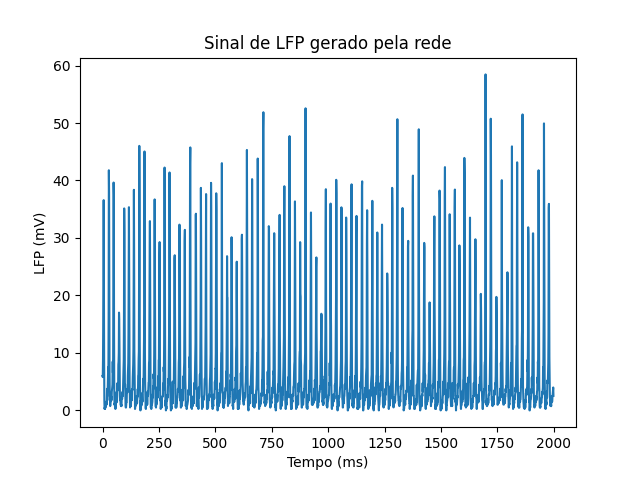

Text(0.5, 1.0, 'Sinal de LFP gerado pela rede')

In [26]:
# Exemplo de sinal de LFP
plt.figure(7)
plt.plot(LFP_1)
plt.xlabel('Tempo (ms)')
plt.ylabel('LFP (mV)')
plt.title('Sinal de LFP gerado pela rede')

<IPython.core.display.Javascript object>


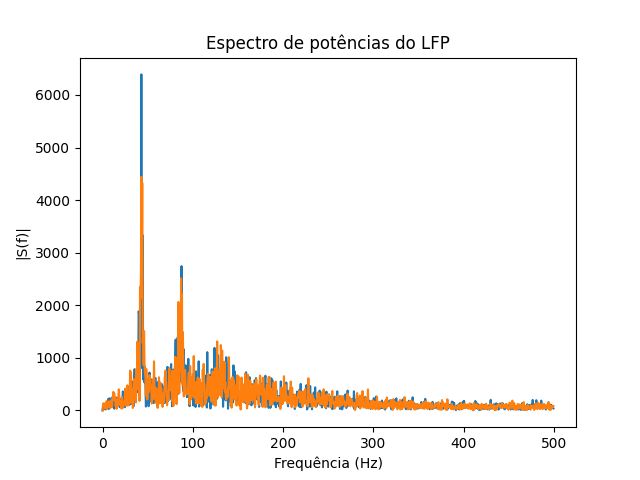

Text(0.5, 1.0, 'Espectro de potências do LFP')

In [27]:
# Exemplo de espectro
freq_1, S_1 = espectro(LFP-np.mean(LFP), passos, dt)
plt.figure(8)
plt.plot(freq_1, S_1)
plt.xlabel('Frequência (Hz)')
plt.ylabel('|S(f)|')
plt.title('Espectro de potências do LFP')

<IPython.core.display.Javascript object>


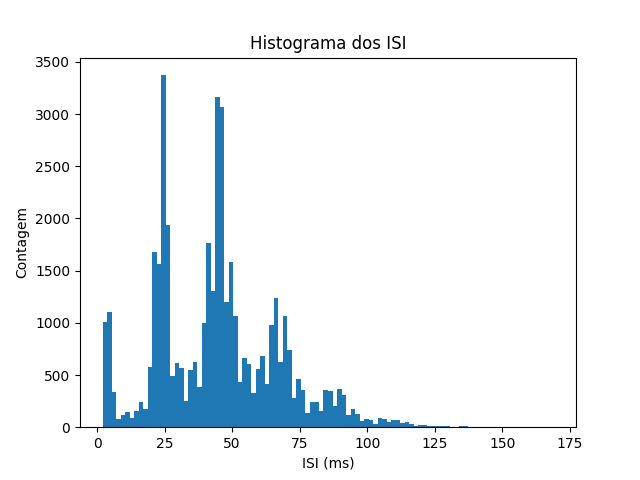

Text(0.5, 1.0, 'Histograma dos ISI')

In [29]:
# Histograma dos ISI

# Dicionário com disparos para cada neurônio
nrn_spikes_1 = {i: [] for i in range(1000)}
for nrn, tspk in disparos_1:
    nrn_spikes_1[nrn].append(tspk)

# Lista com todos os ISI
isis_1 = []
for n in nrn_spikes_1:  # calculamos os ISI para cada um dos neurônios
    tspks = nrn_spikes_1[n]
    isi = np.diff(tspks)
    isis_1.extend(isi)  # listona com todos os ISI da rede

plt.figure(9)
plt.hist(isis_1, bins=100)
plt.xlabel('ISI (ms)')
plt.ylabel('Contagem')
plt.title('Histograma dos ISI')

<IPython.core.display.Javascript object>


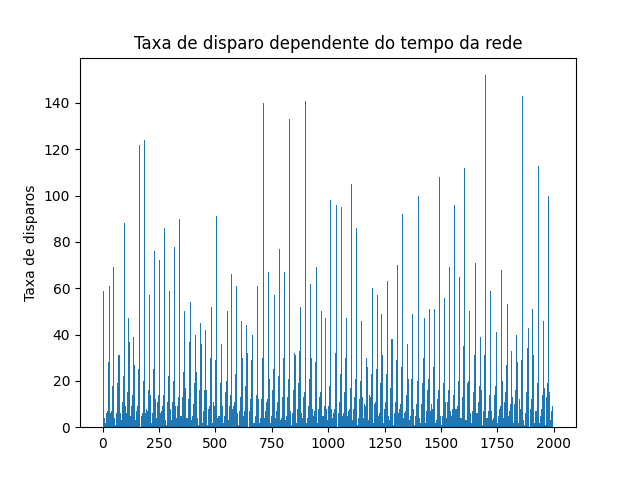

Text(0, 0.5, 'Taxa de disparos')

In [30]:
# Taxa de disparos da rede
plt.figure(10)
plt.hist(disparos_1[:,1], 2000) # histograma com 2000 canaletas
plt.title('Taxa de disparo dependente do tempo da rede')
plt.ylabel('Taxa de disparos')

## Questão 3

Média de 10 simulações:

In [103]:
passos_2 = 2000 # no. de passos na simulação
dt_2 = 0.001 # passo de integração em s
peso_exc_2 = 15
peso_ini_2 = 6
tx_poisson_2 = 100

LFPs = []

for _ in range(10):
    disparos_2, LFP_2 = izhikevich(passos_2, dt_2, tx_poisson_2, peso_exc_2, peso_ini_2)
    LFPs.append(LFP_2)

media = np.array(np.matrix(LFPs).mean(0))

<IPython.core.display.Javascript object>


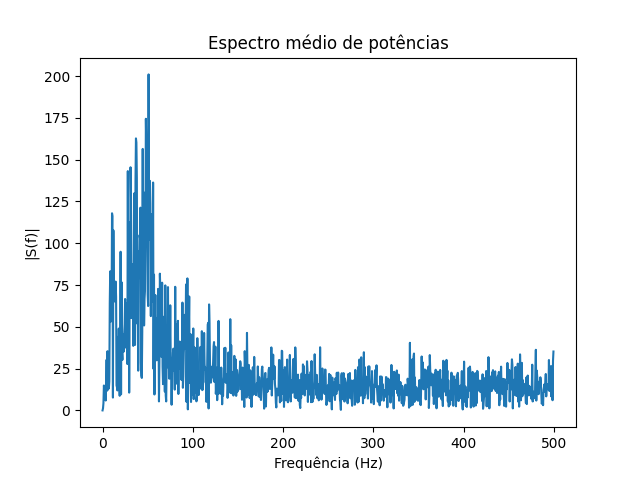

Text(0.5, 1.0, 'Espectro médio de potências')

In [104]:
LFP_basal = np.array(media[0])

freq_2, S_2 = espectro(LFP_basal - np.mean(LFP_basal), passos_2, dt_2)

plt.figure(11)
plt.plot(freq_2, S_2)
plt.xlabel('Frequência (Hz)')
plt.ylabel('|S(f)|')
plt.title('Espectro médio de potências')

Simulando 10 vezes para cinco frequências


<IPython.core.display.Javascript object>


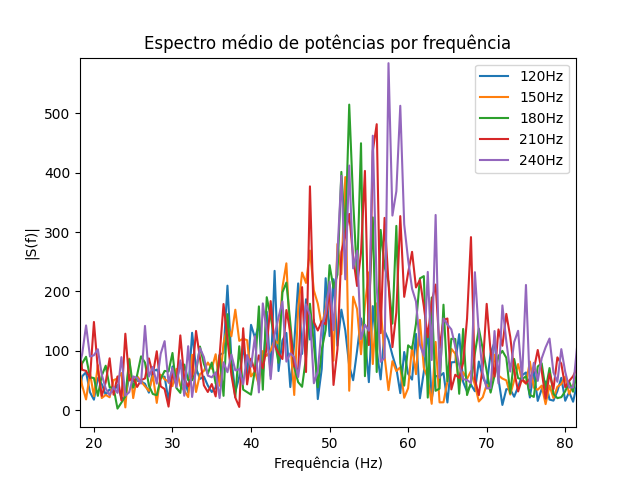

In [110]:
passos_3 = 2000 # no. de passos na simulação
dt_3 = 0.001 # passo de integração em s
peso_exc_3 = 15
peso_ini_3 = 6
tx_poisson_3 = 100

plt.figure(12)

LFP_frequencias = []
for f in np.arange(120, 241, 30):
    LFPs = []   
    for _ in range(10):
        disparos_3, LFP_3 = izhikevich(passos_3, dt_3, f, peso_exc_3, peso_ini_3)
        LFPs.append(LFP_3)
    media = np.array(np.matrix(LFPs).mean(0))[0]
    LFP_frequencias.append(media)
    
    freq_3, S_3 = espectro(media - np.mean(media), passos_3, dt_3)
    plt.plot(freq_3, S_3, label = f'{f}Hz')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('|S(f)|')
    plt.title('Espectro médio de potências por frequência')
    
plt.legend(loc='upper right')   

Basal - espectros de cada frequencia

<IPython.core.display.Javascript object>


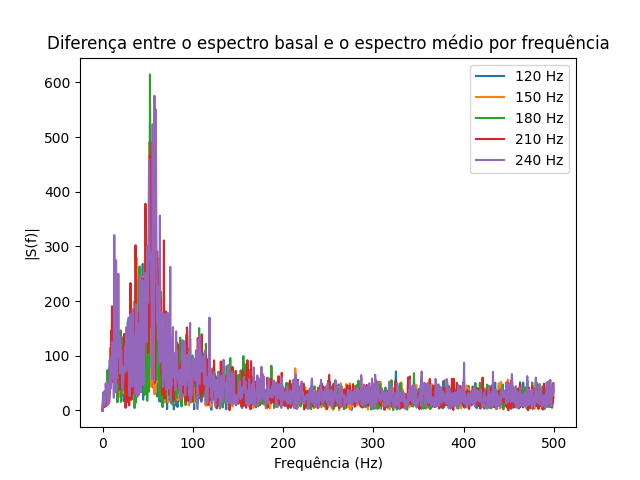

Text(0.5, 1.0, 'Diferença entre o espectro basal e o espectro médio por frequência')

In [111]:
plt.figure(13)
frequencias = np.arange(120, 241, 30)

for f in range(5):
    LFP_f = LFP_frequencias[f]
    diff = LFP_basal - LFP_f
    
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('|S(f)|')
    
    freq_4, S_4 = espectro(diff - np.mean(diff), passos_3, dt_3)
    plt.plot(freq_4, S_4, label=f'{frequencias[f]} Hz')

plt.legend(loc="upper right")
plt.title('Diferença entre o espectro basal e o espectro médio por frequência')    